# Comparison of Bandit-GPC, GPC, and LQR on Linear Dynamical Systems

In [1]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as np
import numpy as onp
import jax.random as random
import tigercontrol
from tigercontrol.utils.random import set_key, generate_key
from tigercontrol.environments import Environment
from tigercontrol.controllers import Controller
from jax import grad,jit

/Users/johnhallman/mlcourse/mlenv/lib/python3.6/site-packages/jax/lib/xla_bridge.py:120: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
set_key(0) # make everything deterministic

In [3]:
from controllers.bpc import BanditGPC
from environments.lds import LDS

In [4]:
n = 3 # dimension of  the state x 
m = 5 # control dimension

problem = LDS()
x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)

Q = 0.1 * np.identity(n)
R = 0.1 * np.identity(m)

loss_fn = lambda x, u: x.T @ Q @ x + u.T @ R @ u

In [5]:
K = np.zeros((m, n))

T = 1000
H = 8
delta = H **0.75 / T**0.25

model = BanditGPC()
model.initialize(problem.A, problem.B, n, m, H, K, delta, x)

In [6]:
BPC_results = onp.zeros(T)
BPC_regret = onp.zeros(T)
c_t = 0 # cost of initial function is 0
for i in range(T):
    u = model.get_action()
    c_t = loss_fn(x, u)
    x = problem.step(u)
    model.update(c_t, x)
    BPC_results[i] = c_t
    BPC_regret[i] = BPC_regret[-1] * i / (i+1) + c_t /(i+1)

In [12]:
print("start: ", np.mean(np.array(BPC_regret[:200])), "end:", np.mean(np.array((BPC_regret[-200:]))))

start:  0.0071471147 end: 0.00015655046


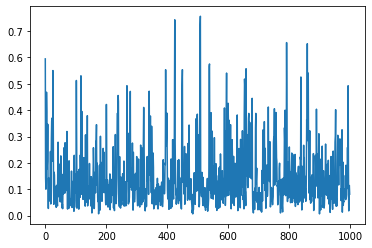

In [10]:
plt.plot(BPC_results)

In [9]:
x = problem.initialize(n, m, d, noise = 0.2)

X = scipy.linalg.solve_discrete_are(problem.A, problem.B, Q, R)
K = np.linalg.inv(B.T @ X @ B + R) @ (B.T @ X @ A)

LQR_results = []
for i in range(T):
    u = -K @ x
    x = problem.step(u)
    LQR_results.append(x)

NameError: name 'd' is not defined

In [ ]:
plt.plot([np.linalg.norm(i) for i in GPC_results], label = "GPC")
plt.plot([np.linalg.norm(i) for i in LQR_results], label = "LQR")
plt.title("GPC vs. LQR on LDS");
plt.legend();

## Using LQR first to get good initial K estimate

In [ ]:
model = GPC()
model.initialize(problem.A, problem.B, x, n, m, 3, 30, K)